# **NLP project. Fake News detection** 

## **Basic imports** ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch
from typing import Optional

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("punkt")
# nltk.download("punkt_tab")
# nltk.download('averaged_perceptron_tagger_eng')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import ClassifierMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [4]:
import warnings
warnings.filterwarnings('ignore')

## **Loading datasets** ##

Datasets are in form of 'True.csv' and 'Fake.csv' files. Although, they seem to be more less balanced (21k and 23k), it is not very convenient to process all articles - instead we will choose 1000 fake and 1000 real articles that will serve as good sample. To achieve this, we will need to utilize some functions from common.py to load, briefly preprocess data and divide it into test and train sets. As a result we will have training and test datasets that are subsets of the whole dataset and without redundant features.

In [5]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 1000)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 1000)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [6]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [7]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

In [10]:
X_train_pre, y_train_pre = cm.clean_data(X_train, y_train)
X_test_pre, y_test_pre = cm.clean_data(X_test, y_test)

## **Preprocessing datasets** ##

Apart from clean_data() function that we defined in common.py, we have 3 methods of preprocessing the data:

1. Generate contextual word embeddings

2. Generate static word embeddings

3. Use lemmatization, stemmatization and create TF-IDF vector

Each of the above methods will be tested on several models and we can compare which model works the best on which type of preprocessing

### **Helper functions** ###

In [ ]:
def load_embeddings(path: str) -> dict[str, np.ndarray]:
    """
    Load word embeddings from a text file into a dictionary.

    Each line in the file should contain a word followed by its embedding vector components,
    separated by spaces.

    Args:
        path (str): Path to the embeddings file.

    Returns:
        dict[str, np.ndarray]: A dictionary mapping words (str) to their embedding vectors (np.ndarray).
    """
    mapping = dict()

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            splitted = line.split(" ")
            mapping[splitted[0]] = np.array(splitted[1:], dtype=float)
    return mapping

def avg_document(doc: str, embeddings: dict[str, np.ndarray]) -> np.ndarray:
        """
        Compute the average embedding vector for a document.

        The function tokenizes the document, looks up each token's embedding,
        and averages all available embeddings. If no tokens have embeddings,
        it returns a zero vector.

        Args:
            doc (str): The input document (text string).
            embeddings (dict[str, np.ndarray]): A dictionary mapping words to embedding vectors.

        Returns:
            np.ndarray: The average embedding vector for the document.
        """

        avg_emb = np.zeros_like(embeddings['italy'])
        tokens = word_tokenize(doc)
        len = 0
        for token in tokens:
            if token in embeddings.keys():
                avg_emb += embeddings[token]
                len+=1
        if len == 0:
            print('No word in glove embeddings for some article!')
            return avg_emb
        return avg_emb/len

def get_wordnet_pos(tag: str) -> str:
    """
    Map Part-of-Speech (POS) tags to WordNet POS constants.

    Args:
        tag (str): The POS tag (e.g., from nltk.pos_tag) to map to a WordNet POS constant.

    Returns:
        str: The corresponding WordNet POS constant (wordnet.ADJ, wordnet.VERB, wordnet.NOUN, or wordnet.ADV).
        Defaults to wordnet.NOUN if the tag does not match any specific category.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_and_stemmatize(
        text: str, 
        stop_words: Optional[set] = stopwords.words('english'), 
        lemmatizer: Optional[WordNetLemmatizer] = WordNetLemmatizer()
    ) -> str:
    """
    Lemmatize and clean a text string by lowercasing, removing digits,
    filtering stop words and non-alphabetic tokens, and applying POS-aware lemmatization.

    Args:
        text (str): The input text string to process.
        stop_words (set, optional): A set of stop words to remove. Defaults to English stopwords.
        lemmatizer (WordNetLemmatizer, optional): An instance of WordNetLemmatizer. Defaults to a new one.

    Returns:
        str: The cleaned, lemmatized text as a single string.
    """
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    word_pattern = re.compile(r"^[^\W\d_]+$", re.UNICODE)

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word_pattern.match(word)]
    pos_tags = pos_tag(filtered_tokens)
    
    lemms = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return " ".join(lemms)

def create_count_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a term-frequency (TF) matrix from the text data in the DataFrame after lemmatization and stemming.

    Args:
        X (pd.DataFrame): DataFrame containing a 'text' column with raw text documents.

    Returns:
        pd.DataFrame: DataFrame where each column corresponds to a term (unigram),
                      and each row contains the term frequency counts for that document.
    """
    for _, row in X.iterrows():
        row['text'] = lemmatize_and_stemmatize(row['text'])

    CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
    CountData = CountVec.fit_transform(X['text'])
    count_data_df = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out())
    return count_data_df

def prepare_test_data(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Omit the words that appear in the test set but not training set (for learning purposes).

    Args:
        X_train (pd.DataFrame): DataFrame containing training set and 'text' column with raw text documents.
        X_test (pd.DataFrame): DataFrame containing testing set and 'text' column with raw text documents.

    Returns:
        pd.DataFrame: DataFrame where each column corresponds to a term (unigram),
                      and each row contains the term frequency counts for that document.
    """
    X_train_cd = create_count_data(X_train)
    X_test_cd = create_count_data(X_test)

    X_test_cd = X_test_cd[X_test_cd.columns.intersection(X_train_cd.columns)]
    X_test_cd[X_train_cd.columns.difference(X_test_cd.columns)] = 0
    X_test_cd = X_test_cd[sorted(X_test_cd.columns)]

    return X_train_cd, X_test_cd

### **Functions used to preprocess the data** ###

In [ ]:
def create_contextual_embeddings(X: pd.DataFrame) -> np.ndarray:
    """
        Create contextual word embeddings for text data using DistilBERT model

        Args:
            X (pd.DataFrame): DataFrame containing a 'text' column with input sentences.

        Returns:
            np.ndarray: Array of contextual embeddings (shape: [num_samples, hidden_size]).
                    Each embedding corresponds to the [CLS] token representation.

    """
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_mask = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    model.eval()
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:,0,:].numpy()

    return features

def create_static_embeddings(X: pd.DataFrame, embeddings: dict[str, np.ndarray]) -> list[np.ndarray]:
    """
        Create static word embeddings for text data by averaging word embeddings per document.

        Args:
            X (pd.DataFrame): DataFrame containing text documents.
            embeddings (dict[str, np.ndarray]): Mapping from words to their static word embeddings vectors.

        Returns:
            list[np.ndarray]: List of numpy arrays awhere each array is the average embedding of a document.

    """
    return [avg_document(doc, embeddings) for doc in X]

def create_TF_IDF(X_train: pd.DataFrame, X_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate TF-IDF representations for the training and test datasets.

    Args:
        X_train (pd.DataFrame): DataFrame containing the training set with a 'text' column.
        X_test (pd.DataFrame): DataFrame containing the testing set with a 'text' column.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: TF-IDF transformed training and test data.
    """
    X_train_cd, X_test_cd = prepare_test_data(X_train, X_test)

    transformer = TfidfTransformer()
    X_train_tfidf = transformer.fit_transform(X_train_cd)
    X_test_tfidf = transformer.fit_transform(X_test_cd)

    return X_train_tfidf, X_test_tfidf
    

### **Function necessary to display most important informations** ###

In [11]:
def display_metrics(model: ClassifierMixin, y_test: np.ndarray, y_pred: np.ndarray, display: bool = True) -> None:
    """
    Print key classification metrics and optionally display a confusion matrix.

    Args:
        model (ClassifierMixin): Trained classification model with attribute `classes_` representing class labels.
        y_test (np.ndarray): True labels for the test set.
        y_pred (np.ndarray): Predicted labels from the model.
        display (bool, optional): Whether to plot and display the confusion matrix. Defaults to True.
    
    Prints:
        Accuracy, F1 score, Recall, and Precision.

    Displays:
        Confusion matrix plot if `display` is True.
    """
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print()
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    
    if display:
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = model.classes_), display_labels=model.classes_)
        disp.plot()
        plt.title("Confusion Matrix")
        plt.show()

## **Aproach 1 - Contextual Word Embeddings** ##

**TO BE DONE**

In [12]:
X_train_contextual = create_contextual_embeddings(X_train_pre)
X_test_contextual = create_contextual_embeddings(X_test_pre)

In [ ]:
# np.save("Embeddings/x_test_contextual_embeddings.npy", X_test_contextual)
# np.save("Embeddings/x_train_contextual_embeddings.npy", X_train_contextual)
# np.save("Embeddings/y_test.npy", y_test_pre)
# np.save("Embeddings/y_train.npy", y_train_pre)

In [14]:
# In case you don't want to generate embeddings from scratch, you can load them from .npy files
# X_train_contextual = np.load("Embeddings/x_train_contextual_embeddings.npy")
# X_test_contextual = np.load("Embeddings/x_test_contextual_embeddings.npy")
# y_train_pre = np.load("Embeddings/y_train.npy")
# y_test_pre = np.load("Embeddings/y_test.npy")

### **Model 1 - SVM** ##

In [15]:
svm = SVC()
svm.fit(X_train_contextual, y_train_pre)

SVC()

Accuracy: 0.9475
F1 score: 0.9484029484029484

Recall: 0.965
Precision: 0.9323671497584541


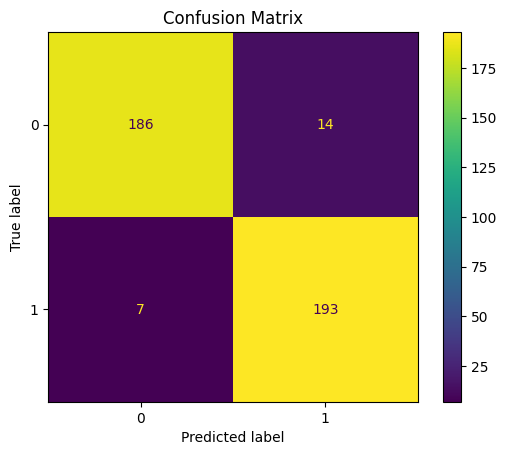

In [16]:
pred_svm_contextual = svm.predict(X_test_contextual)
display_metrics(svm, y_test_pre, pred_svm_contextual)

### **Model 2 - Logistic Regression**

In [17]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_contextual, y_train_pre)

LogisticRegression()

Accuracy: 0.9575
F1 score: 0.9580246913580247

Recall: 0.97
Precision: 0.9463414634146341


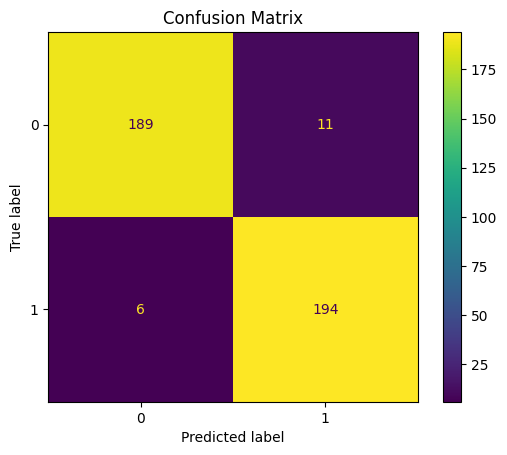

In [18]:
pred_lr_contextual = lr_clf.predict(X_test_contextual)
display_metrics(lr_clf, y_test_pre, pred_lr_contextual)

### **Model 3 - kNN**

In [19]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_contextual, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.9325
F1 score: 0.9346246973365617

Recall: 0.965
Precision: 0.9061032863849765


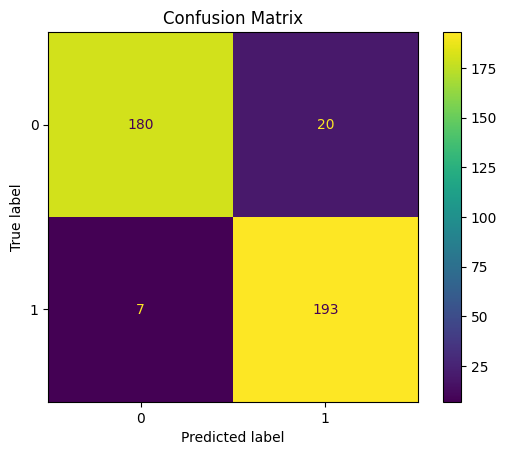

In [20]:
pred_knn_contextual = knn.predict(X_test_contextual)
display_metrics(knn, y_test_pre, pred_knn_contextual)

### **Model 4 - Decision Tree** ##

In [21]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_contextual, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.87
F1 score: 0.8712871287128713

Recall: 0.88
Precision: 0.8627450980392157


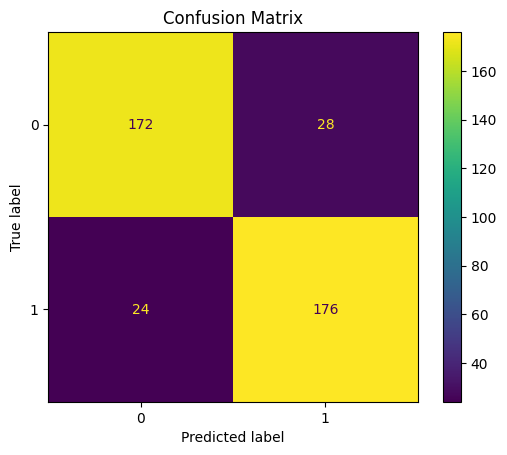

In [22]:
pred_dt_contextual = tree_clf.predict(X_test_contextual)
display_metrics(tree_clf, y_test_pre, pred_dt_contextual)

### **Model 5 - Random Forests** ##

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train_contextual, y_train_pre)

RandomForestClassifier()

Accuracy: 0.94
F1 score: 0.9411764705882353

Recall: 0.96
Precision: 0.9230769230769231


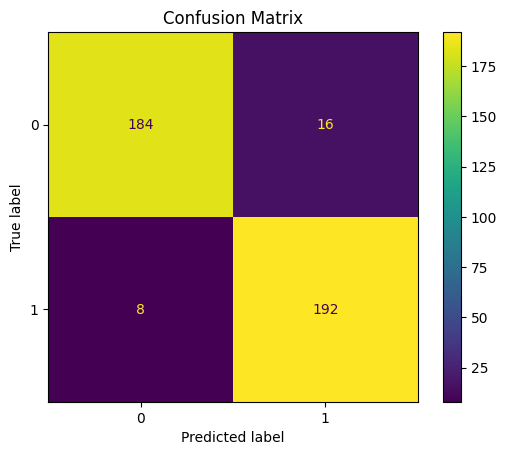

In [24]:
pred_rf_contextual = rf.predict(X_test_contextual)
display_metrics(rf, y_test_pre, pred_rf_contextual)

### **Model 6 - Neural Network**

In [25]:
def build_model(input_shape: tuple = (768,)) -> tf.keras.models.Sequential:
    """
    Build and return a deep neural network model using Keras Sequential API.

    The model consists of several dense layers with ReLU activations,
    interleaved with dropout layers for regularization, and a final sigmoid output layer
    for binary classification.

    Args:
        input_shape (tuple, optional): Shape of the input feature vector. Defaults to (768,).

    Returns:
        tf.keras.models.Sequential: Keras Sequential model ready for training.
    """

    model = Sequential([
    Input(shape=input_shape),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

    return model

model = build_model()
model.compile( optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(X_train_contextual, 
          y_train_pre, 
          validation_split=0.1,
          epochs=50,
          batch_size=32,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), 
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)]
        )

2025-06-11 12:15:01.512557: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-11 12:15:01.512805: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-11 12:15:01.512811: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-11 12:15:01.512871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-11 12:15:01.513135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-11 12:15:02.833917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7124 - loss: 0.5292 - val_accuracy: 0.9312 - val_loss: 0.1960 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9308 - loss: 0.1866 - val_accuracy: 0.9438 - val_loss: 0.1642 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9435 - loss: 0.1785 - val_accuracy: 0.8562 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8955 - loss: 0.2364 - val_accuracy: 0.9500 - val_loss: 0.1528 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9521 - loss: 0.1247 - val_accuracy: 0.9438 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9567 - loss: 0.1308 - val_accuracy: 0.9563 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9536 - loss: 0.1182 - val_accuracy: 0.95

In [26]:
pred_nn_contextual = model.predict(X_test_contextual)
pred_nn_contextual = pred_nn_contextual > 0.5
pred_nn_contextual = np.array([int(i) for i in pred_nn_contextual])

display_metrics(model, y_test_pre, pred_nn_contextual, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.96
F1 score: 0.9597989949748744

Recall: 0.955
Precision: 0.9646464646464646


## **Approach 2 - Static Word Embeddings** ##

**TO BE DONE**

In [27]:
mapping = load_embeddings('glove.6B.50d.txt')
X_train_static = create_static_embeddings(X_train_pre['text'], mapping)
X_test_static = create_static_embeddings(X_test_pre['text'], mapping)

No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for some article!
No word in glove embeddings for so

### **Model 1 - SVM** ##

In [28]:
svm = SVC()
svm.fit(X_train_static, y_train_pre)

SVC()

Accuracy: 0.9025
F1 score: 0.9022556390977443

Recall: 0.9
Precision: 0.9045226130653267


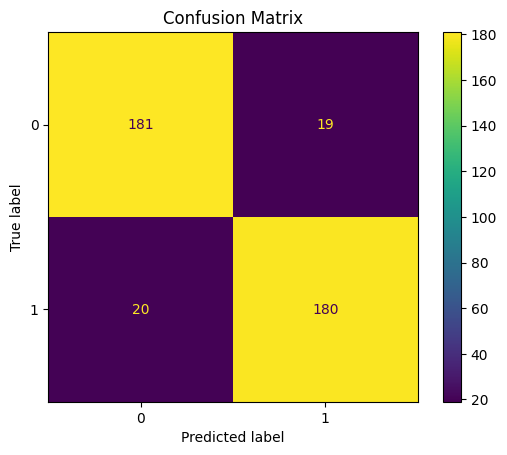

In [29]:
pred_svm_static = svm.predict(X_test_static)
display_metrics(svm, y_test_pre, pred_svm_static)

### **Model 2 - Logistic Regression**

In [30]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_static, y_train_pre)

LogisticRegression()

Accuracy: 0.915
F1 score: 0.914572864321608

Recall: 0.91
Precision: 0.9191919191919192


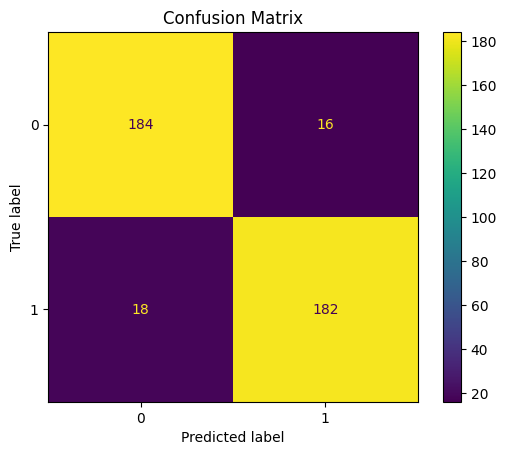

In [31]:
pred_lr_static = lr_clf.predict(X_test_static)
display_metrics(lr_clf, y_test_pre, pred_lr_static)

### **Model 3 - kNN**

In [32]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_static, y_train_pre)

KNeighborsClassifier(n_neighbors=7)

Accuracy: 0.8925
F1 score: 0.8883116883116883

Recall: 0.855
Precision: 0.9243243243243243


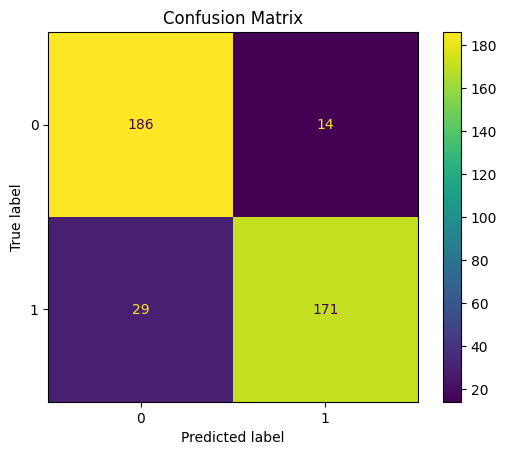

In [33]:
pred_knn_static = knn.predict(X_test_static)
display_metrics(knn, y_test_pre, pred_knn_static)

### **Model 4 - Decision Tree**

In [34]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_static, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.8325
F1 score: 0.8295165394402035

Recall: 0.815
Precision: 0.844559585492228


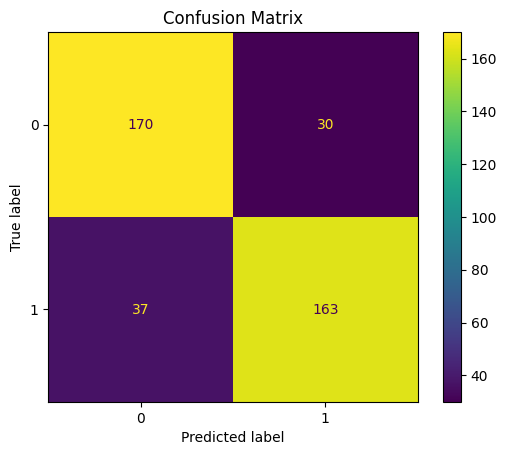

In [35]:
pred_dt_static = tree_clf.predict(X_test_static)
display_metrics(tree_clf, y_test_pre, pred_dt_static)

### **Model 5 - Random Forest**

In [36]:
rf = RandomForestClassifier()
rf.fit(X_train_static, y_train_pre)

RandomForestClassifier()

Accuracy: 0.9025
F1 score: 0.9022556390977443

Recall: 0.9
Precision: 0.9045226130653267


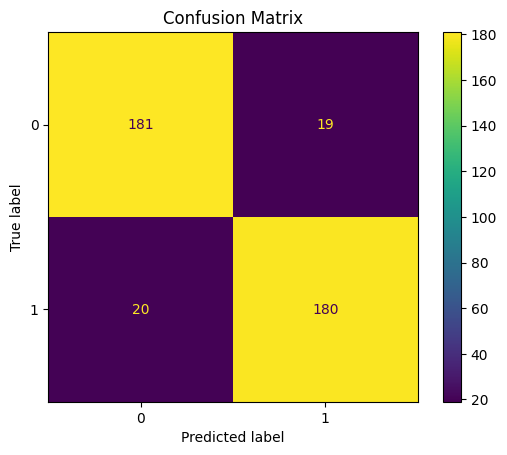

In [37]:
pred_rf_static = rf.predict(X_test_static)
display_metrics(rf, y_test_pre, pred_rf_static)

### **Model 6 - Neural Network**

In [38]:
model = build_model(input_shape=(50,))
model.compile( optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(np.array(X_train_static), 
          y_train_pre, 
          validation_split=0.1,
          epochs=50,
          batch_size=32,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), 
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)]
        )

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5750 - loss: 0.6639 - val_accuracy: 0.8562 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8435 - loss: 0.3871 - val_accuracy: 0.8625 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8679 - loss: 0.3426 - val_accuracy: 0.8125 - val_loss: 0.3728 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8639 - loss: 0.3072 - val_accuracy: 0.8750 - val_loss: 0.3293 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8885 - loss: 0.2953 - val_accuracy: 0.8625 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8659 - loss: 0.3098 - val_accuracy: 0.8875 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8934 - loss: 0.2668 - val_acc

In [39]:
pred_nn_static = model.predict(np.array(X_test_static))
pred_nn_static = pred_nn_static > 0.5
pred_nn_static = np.array([int(i) for i in pred_nn_static])

display_metrics(model, y_test_pre, pred_nn_static, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.9075
F1 score: 0.9072681704260651

Recall: 0.905
Precision: 0.9095477386934674


## **Approach 3 - TF-IDF vector** ##

**TO BE DONE**

In [60]:
X_train_tfidf, X_test_tfidf = create_TF_IDF(X_train_pre, X_test_pre)

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

### **Model 1 - SVM** ###

Accuracy: 0.9275
F1 score: 0.9280397022332506

Recall: 0.935
Precision: 0.9211822660098522


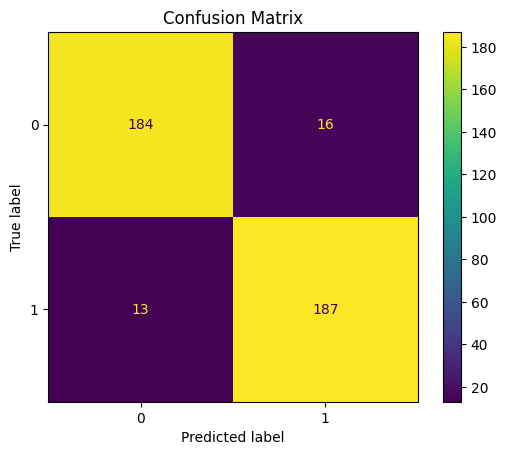

In [61]:
svm = SVC()
svm.fit(X_train_tfidf, y_train_pre)

pred_svm_tfidf = svm.predict(X_test_tfidf)
display_metrics(svm, y_test_pre, pred_svm_tfidf)

### **Model 2 - Logistic Regression** ###

Accuracy: 0.92
F1 score: 0.9207920792079208

Recall: 0.93
Precision: 0.9117647058823529


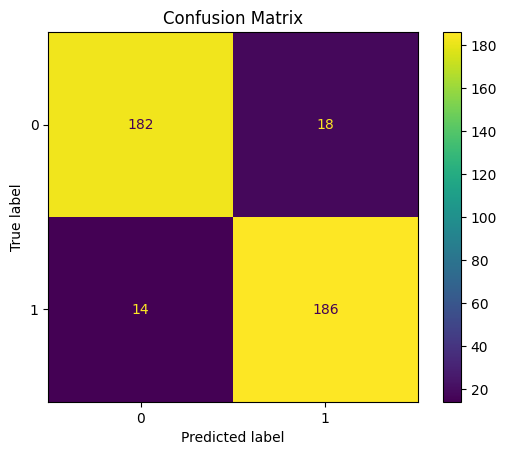

In [62]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train_pre)

pred_lr_tfidf = lr.predict(X_test_tfidf)
display_metrics(lr, y_test_pre, pred_lr_tfidf)

### **Model 3 - kNN** ###

Accuracy: 0.5
F1 score: 0.0

Recall: 0.0
Precision: 0.0


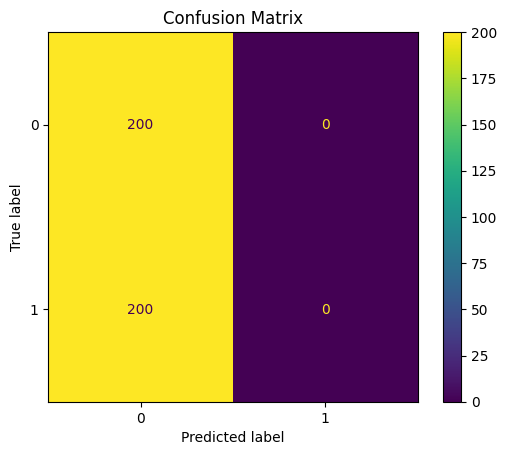

In [63]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tfidf, y_train_pre)

pred_knn_tfidf = knn.predict(X_test_tfidf)
display_metrics(knn, y_test_pre, pred_knn_tfidf)

### **Model 4 - Decision Tree** ###

Accuracy: 0.83
F1 score: 0.8291457286432161

Recall: 0.825
Precision: 0.8333333333333334


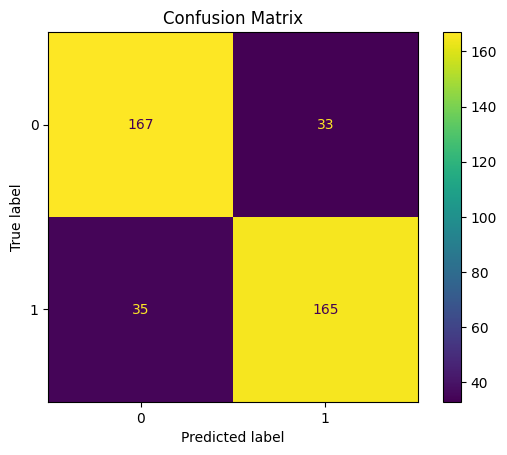

In [64]:
tree_clf = DecisionTreeClassifier(criterion='entropy')
tree_clf.fit(X_train_tfidf, y_train_pre)

pred_dt_tfidf = tree_clf.predict(X_test_tfidf)
display_metrics(tree_clf, y_test_pre, pred_dt_tfidf)

### **Model 5 - Random Forrests** ###

Accuracy: 0.9375
F1 score: 0.9385749385749386

Recall: 0.955
Precision: 0.9227053140096618


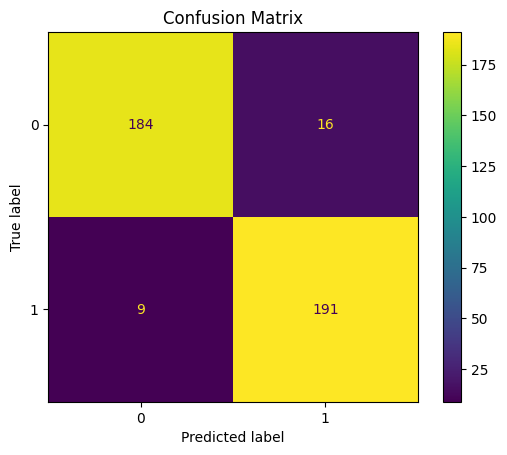

In [65]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train_pre)

pred_rf_tfidf = rf.predict(X_test_tfidf)
display_metrics(rf, y_test_pre, pred_rf_tfidf)

### **Model 6 - Neural Network**

In [66]:
model = build_model(input_shape=(X_train_tfidf.shape[1],))
model.compile( optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(np.array(X_train_tfidf), 
          y_train_pre, 
          validation_split=0.1,
          epochs=50,
          batch_size=32,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), 
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)]
        )

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6193 - loss: 0.6623 - val_accuracy: 0.9438 - val_loss: 0.1782 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9658 - loss: 0.1099 - val_accuracy: 0.9375 - val_loss: 0.2285 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9971 - loss: 0.0135 - val_accuracy: 0.9000 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 4/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9125 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 3.6318e-04 - val_accuracy: 0.9125 - val_loss: 0.3193 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 3.9191e-0

In [67]:
pred_nn_tfidf = model.predict(np.array(X_test_tfidf))
pred_nn_tfidf= pred_nn_tfidf > 0.5
pred_nn_tfidf = np.array([int(i) for i in pred_nn_tfidf])

display_metrics(model, y_test_pre, pred_nn_tfidf, False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.92
F1 score: 0.92

Recall: 0.92
Precision: 0.92


## **Summary and comparison of the results** ##

In [69]:
summary = pd.DataFrame(index = ['SVM', 'Linear Regression', 'kNN', 'Decision Tree', 'Random Forest', 'Neural Network'], columns = ['contextual', 'static', 'tfidf'])
statics = [pred_svm_static, pred_lr_static, pred_knn_static, pred_dt_static, pred_rf_static, pred_nn_static]
statics_acc = []

contextuals = [pred_svm_contextual, pred_lr_contextual, pred_knn_contextual, pred_dt_contextual, pred_rf_contextual, pred_nn_contextual]
contextuals_acc = []

tfidfs = [pred_svm_tfidf, pred_lr_tfidf, pred_knn_tfidf, pred_dt_tfidf, pred_rf_tfidf, pred_nn_tfidf]
tfidfs_acc = []

for st, ct, tfidf in zip(statics, contextuals, tfidfs):
    statics_acc.append(accuracy_score(y_test_pre, st))
    contextuals_acc.append(accuracy_score(y_test_pre, ct))
    tfidfs_acc.append(accuracy_score(y_test_pre, tfidf))

summary.static = statics_acc
summary.contextual = contextuals_acc
summary.tfidf = tfidfs_acc

print("Accuracies for different preprocessing and different models")
summary

Accuracies for different preprocessing and different models


,contextual,static,tfidf
SVM,0.9475,0.9025,0.9275
Linear Regression,0.9575,0.9150,0.9200
kNN,0.9325,0.8925,0.5000
Decision Tree,0.8700,0.8325,0.8300
Random Forest,0.9400,0.9025,0.9375
Neural Network,0.9600,0.9075,0.9200


### **Key Takeaways** ###

•  **Contextual word embeddings (DistilBERT)** achieved the **highest accuracy across all models**, especially when used with Neural Networks and Logistic Regression.

• **Static word embeddings (GloVe 50d)** offer a solid compromise, delivering **over 90% accuracy** with minimal computational cost, making them more suitable for real-world or large-scale applications.

•  **TF-IDF** performed surprisingly  well on this dataset, especially with models like Random Forest and SVM, but it **may not generalize well** to other domains without a significantly larger and more diverse text base. Also, it had really poor results on kNN classifier.

•  In terms of models, the ones with best performances were Logistic Regression and Neural Network. However, SVM and Random Forests also had good accuracies (all four had accuracies above 90%). Among above models, only poor performance we noticed was kNN classifier on TF-IDF (accuracy of 50%) and performance of Decision Tree was solid but not superior (above 80% but below neural network and logistic regression).

### **Limitations** ###
• Generating contextual word embeddings is **computationally expensive and time-consuming**

• Generating static word embeddings is **computationally lightweight** but requires downloading proper file (glove) in advance. Depending which file one choses to use, there may be some problems that will arise with its size

•  TF-IDF in particular is highly domain-sensitive and may underperform without extensive corpus coverage. It also has one big drawback - it requires a lot of memory, because the dataframe has 10k features for a small subset (we know that in total there are 87k different words). It can be also seen when training SVM model - for word embeddings, fitting lasted 1-2 seconds while for TF-IDF matrix it was 20 seconds.

•  Results are dataset-specific and may not translate directly to more diverse or real-world fake news datasets.

•  Resource constraints were not explicitly measured but are a critical consideration in deployment scenarios.


### **Conclusion** ###

While **contextual embeddings provide the best raw performance**, **static word embeddings appear to be the most practical choice** when balancing **accuracy, efficiency, and scalability**.

In terms of model, the one offering highest statistics and thus most suitable for detecting fake news were custom **Neural Network** and **Logistic Regression**.